# GoDaddy - Microbusiness Density Forecasting - Kaggle Competition
---
---

### Dataset Description
Your challenge in this competition is to forecast microbusiness activity across the United States, as measured by the density of microbusinesses in US counties. Microbusinesses are often too small or too new to show up in traditional economic data sources, but microbusiness activity may be correlated with other economic indicators of general interest.

As historic economic data are widely available, this is a forecasting competition. The forecasting phase public leaderboard and final private leaderboard will be determined using data gathered after the submission period closes. You will make static forecasts that can only incorporate information available before the end of the submission period. This means that while we will rescore submissions during the forecasting period we will not rerun any notebooks.

### Files
A great deal of data is publicly available about counties and we have not attempted to gather it all here. You are strongly encouraged to use external data sources for features.

### train.csv

- row_id - An ID code for the row.

- cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

- county_name - The written name of the county.

- state_name - The name of the state.

- first_day_of_month - The date of the first day of the month.

- microbusiness_density - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.

- active - The raw count of microbusinesses in the county. Not provided for the test set.

### sample_submission.csv 

A valid sample submission. This file will remain unchanged throughout the competition.

- row_id - An ID code for the row.

- microbusiness_density - The target variable.

### test.csv 

Metadata for the submission rows. This file will remain unchanged throughout the competition.

- row_id - An ID code for the row.

- cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

- first_day_of_month - The date of the first day of the month.

### revealed_test.csv
During the submission period, only the most recent month of data will be used for the public leaderboard. Any test set data older than that will be published in revealed_test.csv, closely following the usual data release cycle for the microbusiness report. We expect to publish one copy of revealed_test.csv in mid February. This file's schema will match train.csv.

### census_starter.csv 
Examples of useful columns from the Census Bureau's American Community Survey (ACS) at data.census.gov. The percentage fields were derived from the raw counts provided by the ACS. All fields have a two year lag to match what information was avaiable at the time a given microbusiness data update was published.

- pct_bb_[year] - The percentage of households in the county with access to broadband of any type. Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.

- cfips - The CFIPS code.

- pct_college_[year] - The percent of the population in the county over age 25 with a 4-year college degree. Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.

- pct_foreign_born_[year] - The percent of the population in the county born outside of the United States. Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.

- pct_it_workers_[year] - The percent of the workforce in the county employed in information related industries. Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.

- median_hh_inc_[year] - The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

In [ ]:
## installing required packages
!pip install catboost

## Importing relevant libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set()
import warnings 
from sklearn.linear_model import (LinearRegression, Lasso, Ridge, ElasticNet, 
                                  MultiTaskLasso, MultiTaskElasticNet, 
                                  BayesianRidge, ARDRegression, RANSACRegressor, 
                                  TheilSenRegressor, HuberRegressor, 
                                  PassiveAggressiveRegressor, LogisticRegressionCV)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor, BaggingRegressor)

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor, BaggingRegressor)

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold, GridSearchCV
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor 
warnings.filterwarnings('ignore')

## Getting Dataset

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

## Exploratory Data Analysis

In [ ]:
df_train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0


In [ ]:
df_train.describe(include = 'all')

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
count,14677,14677.000000,14677,14677,14677,14676.000000,1.467600e+04
unique,14677,NaN,333,10,40,NaN,NaN
top,1001_2019-08-01,NaN,Jackson County,Arkansas,2019-08-01,NaN,NaN
freq,1,NaN,156,2925,377,NaN,NaN
mean,NaN,5989.711249,NaN,NaN,NaN,5.380779,1.874729e+04
std,NaN,3539.784900,NaN,NaN,NaN,6.017006,7.604775e+04
min,NaN,1001.000000,NaN,NaN,NaN,0.247328,1.200000e+01
25%,NaN,4001.000000,NaN,NaN,NaN,1.677686,1.750000e+02
50%,NaN,6009.000000,NaN,NaN,NaN,3.474321,8.390000e+02
75%,NaN,8079.000000,NaN,NaN,NaN,6.851778,8.044250e+03


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14677 entries, 0 to 14676
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   row_id                 14677 non-null  object 
 1   cfips                  14677 non-null  int64  
 2   county                 14677 non-null  object 
 3   state                  14677 non-null  object 
 4   first_day_of_month     14677 non-null  object 
 5   microbusiness_density  14676 non-null  float64
 6   active                 14676 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 802.8+ KB


In [ ]:
print(f'The unique values of cfips are: {df_train.cfips.nunique()}')

The unique values of cfips are: 377


In [ ]:
def plot_cfips(cfips):
    # getting data for cfips, resetign the index and ploting
    df_train[df_train['cfips'] == cfips].reset_index().microbusiness_density.plot(
                                                                    title='Microbusiness Density',
                                                                    label=f'cfips: {cfips}', 
                                                                    legend = True,
                                                                    style= '-',
                                                                    xlabel = 'Date Range',
                                                                    ylabel = 'Microbusiness Density')

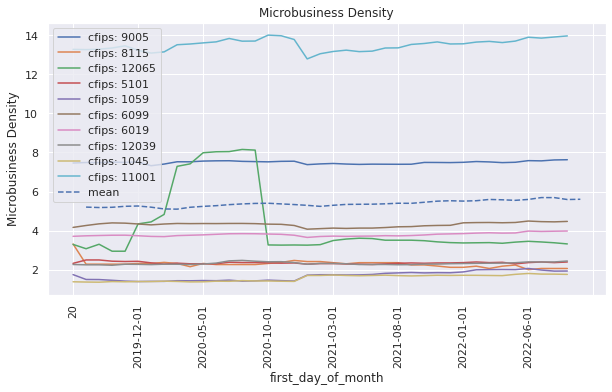

In [ ]:
plt.figure(figsize= (10, 5))
for i in range(10):
    # ploting 10 random cfips
    plot_cfips(np.random.choice(df_train.cfips.unique()))
# ploting the mean business density of all cfips in the same date range
df_train.groupby('first_day_of_month')['microbusiness_density'].mean().plot(label='mean',
                                                                            style = '--',
                                                                            legend = True)
plt.xticks(rotation='vertical')
plt.show()

### Findings
- The unique cfips number is 3135
- For each cfips we have 39 months of data - first_day_of_month
- The microbusiness density varies from 0.00 to 284.34 with a mean of 3.817 and standard deviation of 4.9
- By analyzing the above graphs it seems like we'll have seperate model for each county

## Feature Engineering

In [ ]:
train_data = {
    # create array of 39 values as the training dataset contain 39 months of data for each county
    'x': np.arange(1, 40).reshape(-1, 1), 
    # organize the data group wise for each county and assign to mbd
    'mbd' : df_train.sort_values(['first_day_of_month']).groupby('cfips')['microbusiness_density'].apply(lambda x: x.values)
}

# As we need to predict the next 8 months of data in the test file  
test_data = np.arange(40, 48).reshape(-1, 1)

In [ ]:
# train - test data splitting
test_size = 8 # 8 months of data to be predicting
total_size = train_data['mbd'].values[0].shape[0] # size of total months for unique cfips

# training samples
X_train = train_data['x'][-total_size:-test_size].reshape(-1, 1)
y_train = train_data['mbd'].apply(lambda x: x[-total_size:-test_size])

# test samples
X_test = train_data['x'][-test_size:].reshape(-1, 1)
y_test = train_data['mbd'].apply(lambda x: x[-test_size:])

cfips_unique = df_train.cfips.unique()

## Model Training

In [ ]:
# initializing all the models
linear_regression = LinearRegression()
lasso = Lasso()
ridge = Ridge()
elastic_net = ElasticNet()
multi_task_lasso = MultiTaskLasso()
multi_task_elastic_net = MultiTaskElasticNet()
bayesian_ridge = BayesianRidge()
ard_regression = ARDRegression()
ransac_regressor = RANSACRegressor()
theil_sen_regressor = TheilSenRegressor()
huber_regressor = HuberRegressor()
passive_aggressive_regressor = PassiveAggressiveRegressor()
logistic_regression_cv = LogisticRegressionCV()
decision_tree_regressor = DecisionTreeRegressor()
k_neighbors_regressor = KNeighborsRegressor()
random_forest_regressor = RandomForestRegressor()
gradient_boosting_regressor = GradientBoostingRegressor()
ada_boost_regressor = AdaBoostRegressor()
bagging_regressor = BaggingRegressor()
svr = SVR()
mlp_regressor = MLPRegressor()
gaussian_process_regressor = GaussianProcessRegressor()
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
lgb = LGBMRegressor()
cbr = CatBoostRegressor()

regressors_list = [linear_regression, lasso, ridge, elastic_net, multi_task_lasso, 
                  multi_task_elastic_net, bayesian_ridge, ard_regression, 
                  ransac_regressor, theil_sen_regressor, huber_regressor, 
                  passive_aggressive_regressor, logistic_regression_cv, 
                  decision_tree_regressor, k_neighbors_regressor, random_forest_regressor,
                  gradient_boosting_regressor, ada_boost_regressor, bagging_regressor,
                  svr, mlp_regressor, gaussian_process_regressor, xgb_model, lgb, cbr]

regressors_list.remove(random_forest_regressor)
regressors_list.remove(multi_task_lasso)
regressors_list.remove(multi_task_elastic_net)
regressors_list.remove(logistic_regression_cv)

In [ ]:
def calculate_smape(actual, predicted) -> float:
  
    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        ), 2
    )

In [ ]:
def process(models, viz = False):
    results = {}
    for model in tqdm(models, desc = 'processing models: '):
        smape_total = 0
        for cfip in cfips_unique:
            #print(model)
            model.fit(X_train, y_train[cfip]) 
            y_pred = model.predict(X_test)
            smape = calculate_smape(y_test[cfip], y_pred)
            
            smape_total +=smape

            if viz:
                plt.plot(train_data['x'], train_data['mbd'][cfip], label='train')
                plt.plot(X_test, y_pred, label = 'predicted')
                plt.legend()
                plt.show()
        results[model] = round((smape_total/len(cfips_unique)), 5)

    return pd.DataFrame(results.values(), index = results.keys(), columns = ['smape'])    

In [ ]:
process([gradient_boosting_regressor, xgb_model, lgb], False)

In [ ]:
process(regressors_list, False)

## Model Evaluaiton

In [ ]:
# By evaluating different models with smape the following models give better results
#svr, HuberRegressor, ARDRegression, BayesianRidge, ElasticNet, Ridge, Lasso, gradient_boosting_regressor

## Model optimization

### Combining models

In [ ]:
models = [('svr', svr), ('huber', huber_regressor), ('ard', ard_regression), ('bayesian', bayesian_ridge),
        ('elastic_net', elastic_net), ('ridge', ridge), ('lasso', lasso), ('gbr', gradient_boosting_regressor)]

### Voting
First train individual model in the list. Then we store these models in a list and pass it to the VotingRegressor class. This class will take average of predictions of all the models in the list. Finally, we fit the ensemble to the training data and use it to make predictions on the test data.

In [ ]:
ensemble = VotingRegressor(models)
smape_total = 0
for cfip in tqdm(cfips_unique, desc = 'Processing cfips: '):
    ensemble.fit(X_train, y_train[cfip]) 
    y_pred = ensemble.predict(X_test)
    smape = calculate_smape(y_test[cfip], y_pred)

    smape_total +=smape

    if viz:
        plt.plot(train_data['x'], train_data['mbd'][cfip], label='train')
        plt.plot(X_test, y_pred, label = 'predicted')
        plt.legend()
        plt.show()
results = round((smape_total/len(cfips_unique)), 5)
print(results)

Processing cfips: 100%|█████████████████████| 3135/3135 [01:42<00:00, 30.64it/s]

0.05928


### Stacking
The StackingRegressor class use the predictions of all the models in the list as inputs to the final estimator to make the final prediction. Finally, we fit the ensemble to the training data and use it to make predictions on the test data.

In [ ]:
ensemble = StackingRegressor(estimators=models, final_estimator=LinearRegression())
smape_total = 0
for cfip in tqdm(cfips_unique, desc = 'Processing cfips: '):
    ensemble.fit(X_train, y_train[cfip]) 
    y_pred = ensemble.predict(X_test)
    smape = calculate_smape(y_test[cfip], y_pred)

    smape_total +=smape

    if viz:
        plt.plot(train_data['x'], train_data['mbd'][cfip], label='train')
        plt.plot(X_test, y_pred, label = 'predicted')
        plt.legend()
        plt.show()
results = round((smape_total/len(cfips_unique)), 5)
print(results)

Processing cfips: 100%|█████████████████████| 3135/3135 [10:28<00:00,  4.99it/s]

0.1808


### Blending
Here, we first train individual models for SVR, HuberRegressor, ARDRegression, BayesianRidge, ElasticNet, Ridge, Lasso on the training data. Then we make predictions on the test data for each of the models. Finally, we combine the predictions by taking a weighted average of the predictions of all models. The weight can be determined by you, and you can use different weighting scheme and check the performance on the test set.

In [ ]:
smape_total = 0
for cfip in tqdm(cfips_unique, desc = 'Processing cfips: '):
    
    # Fit individual models to the training data
    svr.fit(X_train, y_train[cfip]) 
    huber_regressor.fit(X_train, y_train[cfip]) 
    ard_regression.fit(X_train, y_train[cfip]) 
    bayesian_ridge.fit(X_train, y_train[cfip]) 
    elastic_net.fit(X_train, y_train[cfip]) 
    ridge.fit(X_train, y_train[cfip]) 
    lasso.fit(X_train, y_train[cfip]) 
    gradient_boosting_regressor.fit(X_train, y_train[cfip]) 
    

    # Make predictions on the test data
    svr_pred = svr.predict(X_test)
    huber_pred = huber_regressor.predict(X_test)
    ard_pred = ard_regression.predict(X_test)
    bayesian_pred = bayesian_ridge.predict(X_test)
    elastic_net_pred = elastic_net.predict(X_test)
    ridge_pred = ridge.predict(X_test)
    lasso_pred = lasso.predict(X_test)
    gbr_pred = gradient_boosting_regressor.predict(X_test)
    
    # Combine the predictions using a weighted average
    weights = [0.3, 0.,  0.1, 0., 0.,  0.1, 0.,  0.5]
    #weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3]
    final_pred = weights[0]*svr_pred + weights[1]*huber_pred \
    + weights[2]*ard_pred + weights[3]*bayesian_pred + weights[4]*elastic_net_pred \
    + weights[5]*ridge_pred + weights[6]*lasso_pred + weights[7]*gbr_pred
    
    smape = calculate_smape(y_test[cfip], final_pred)

    smape_total +=smape

    if viz:
        plt.plot(train_data['x'], train_data['mbd'][cfip], label='train')
        plt.plot(X_test, y_pred, label = 'predicted')
        plt.legend()
        plt.show()
results = round((smape_total/len(cfips_unique)), 5)
print(results)

Processing cfips: 100%|█████████████████████| 3135/3135 [01:35<00:00, 32.86it/s]

0.04424


#### Hyperparameter tuning - GrisSearch Cross Validation

In [ ]:
# Define the parameter grid for the weighting scheme
param_grid = {'weights': [np.array([w1, w2, w3, w4, w5, w6, w7, w8])\
                          for w1 in np.arange(0, 1.1, 0.1) \
                          for w2 in np.arange(0, 1.1, 0.1) \
                          for w3 in np.arange(0, 1.1, 0.1) \
                          for w4 in np.arange(0, 1.1, 0.1) \
                          for w5 in np.arange(0, 1.1, 0.1) \
                          for w6 in np.arange(0, 1.1, 0.1) \
                          for w7 in np.arange(0, 1.1, 0.1) \
                          for w8 in np.arange(0, 1.1, 0.1) if sum([w1, w2, w3, w4, w5, w6, w7, w8]) == 1]}

# Create a KFold cross-validator
cv = KFold(n_splits=4, shuffle=True, random_state=42)

In [ ]:
import random
param_grid_n = {}
param_grid_n['weights'] = random.sample(param_grid['weights'], 20) # get 20 randomly due to plenty of combinations

In [ ]:
# models with having better smape score relatively
models = [('svr', svr), ('huber', huber_regressor), ('ard', ard_regression), ('bayesian', bayesian_ridge),
        ('elastic_net', elastic_net), ('ridge', ridge), ('lasso', lasso), ('gbr', gradient_boosting_regressor)]
# get models only
model_list = []
for i in models:
    model_list.append(i[1])

In [ ]:
class Blender:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        predictions = [model.predict(X) for model in self.models]
        return np.average(predictions, axis=0, weights=self.weights)

    def get_params(self, deep=True):
        return {'models': self.models, 'weights': self.weights}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


# Create the blender object with the individual models and the initial weighting scheme
blender = Blender(models = [SVR(),
 HuberRegressor(),
 ARDRegression(),
 BayesianRidge(),
 ElasticNet(),
 Ridge(),
 Lasso(),
 GradientBoostingRegressor()], weights=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
smape_total = 0
# Create a KFold cross-validator
cv = KFold(n_splits=4, shuffle=False)
# Define a function to combine the predictions using a weighted average
def blended_predictions(weights):
    return np.average(predictions, axis=0, weights=weights)

for cfip in tqdm(cfips_unique[:10], desc = 'Processing cfips: '):
    
    # Fit individual models to the training data
    svr.fit(X_train, y_train[cfip]) 
    huber_regressor.fit(X_train, y_train[cfip]) 
    ard_regression.fit(X_train, y_train[cfip]) 
    bayesian_ridge.fit(X_train, y_train[cfip]) 
    elastic_net.fit(X_train, y_train[cfip]) 
    ridge.fit(X_train, y_train[cfip]) 
    lasso.fit(X_train, y_train[cfip]) 
    gradient_boosting_regressor.fit(X_train, y_train[cfip]) 
    

    # Make predictions on the test data
    svr_pred = svr.predict(X_test)
    huber_pred = huber_regressor.predict(X_test)
    ard_pred = ard_regression.predict(X_test)
    bayesian_pred = bayesian_ridge.predict(X_test)
    elastic_net_pred = elastic_net.predict(X_test)
    ridge_pred = ridge.predict(X_test)
    lasso_pred = lasso.predict(X_test)
    gbr_pred = gradient_boosting_regressor.predict(X_test)
    
    # Grid Search: 
    predictions = [svr_pred, huber_pred, ard_pred, bayesian_pred, elastic_net_pred, ridge_pred, lasso_pred, gbr_pred]
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=blender, param_grid=param_grid_n, cv=cv, scoring='neg_mean_squared_error')

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train[cfip]) 

    # Use the best parameters to make predictions on the test data
    best_weights = grid_search.best_params_['weights']
    final_pred = blended_predictions(best_weights)
    
    #print(best_weights)

    smape = calculate_smape(y_test[cfip], final_pred)

    smape_total +=smape

    if viz:
        plt.plot(train_data['x'], train_data['mbd'][cfip], label='train')
        plt.plot(X_test, y_pred, label = 'predicted')
        plt.legend()
        plt.show()
results = round((smape_total/len(cfips_unique)), 5)
print(results)

Processing cfips: 100%|█████████████████████████| 10/10 [00:24<00:00,  2.50s/it]

0.0002


### Gradient Boosting Regression - Hyperparameter tunning

In [ ]:
GradientBoostingRegressor().get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
gbr = GradientBoostingRegressor(n_estimators= 250, learning_rate = 1, max_depth = 5)  #0.03715
smape_total = 0
for cfip in tqdm(cfips_unique, desc = f'Processing cfips: '):
    
    # Fit the GridSearchCV object to the data
    gbr.fit(X_train, y_train[cfip]) 
    
    # Make predictions
    y_pred = gbr.predict(X_test)

    smape = calculate_smape(y_test[cfip], y_pred)

    smape_total +=smape
results = round((smape_total/len(cfips_unique)), 5)
print(results)

Processing cfips: 100%|█████████████████████| 3135/3135 [02:18<00:00, 22.69it/s]

nan


In [ ]:
gbr = GradientBoostingRegressor()
smape_total = 0

# Define the parameter grid for the grid search
param_grid = {'n_estimators': [100, 250, 500],
              'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 4, 5],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 4]}


for cfip in tqdm(cfips_unique, desc = f'Processing cfips: '):
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(gbr, param_grid, cv=4, n_jobs=-1)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train[cfip]) 
    
    # Use the best hyperparameters to train a new GradientBoostingRegressor model
    best_gbr = GradientBoostingRegressor(**grid_search.best_params_)
    best_gbr.fit(X_train, y_train[cfip]) 
    

    # Make predictions
    y_pred = best_gbr.predict(X_test)

    smape = calculate_smape(y_test[cfip], y_pred)

    smape_total +=smape
        
    # training on all data and predicting
    best_gbr.fit(train_data['x'], train_data['mbd'][cfip]) 
    y_pred = best_gbr.predict(test_data)
    
    # adding the predicted data to test file 
    df_test.loc[df_test['cfips'] == cfip, 'microbusiness_density'] = y_pred
    
    

results = round((smape_total/len(cfips_unique)), 5)
print(results)

# Create submission DataFrame with row_id and microbusiness_density columns from df_test
df_submission = df_test[['row_id', 'microbusiness_density']]

# Save submission DataFrame to CSV file
df_submission.to_csv('submission_17.csv', index = False)


## Finalizing the model

In [ ]:
ensemble = VotingRegressor(models)
for cfip in tqdm(cfips_unique, desc = 'Processing cfips: '):
    ensemble.fit(train_data['x'], train_data['mbd'][cfip]) 
    y_pred = ensemble.predict(test_data)
    
    # adding the predicted data to test file 
    df_test.loc[df_test['cfips'] == cfip, 'microbusiness_density'] = y_pred
    

    if viz:
        plt.plot(train_data['x'], train_data['mbd'][cfip], label='train')
        plt.plot(test_data, y_pred, label = 'predicted')
        plt.legend()
        plt.show()
        
# Create submission DataFrame with row_id and microbusiness_density columns from df_test
df_submission = df_test[['row_id', 'microbusiness_density']]

# Save submission DataFrame to CSV file
df_submission.to_csv('submission_13.csv', index = False)

Processing cfips: 100%|█████████████████████| 3135/3135 [01:43<00:00, 30.29it/s]


In [ ]:
ensemble = GradientBoostingRegressor()
for cfip in tqdm(cfips_unique, desc = 'Processing cfips: '):
    ensemble.fit(train_data['x'], train_data['mbd'][cfip]) 
    y_pred = ensemble.predict(test_data)
    
    # adding the predicted data to test file 
    df_test.loc[df_test['cfips'] == cfip, 'microbusiness_density'] = y_pred
    

    if viz:
        plt.plot(train_data['x'], train_data['mbd'][cfip], label='train')
        plt.plot(test_data, y_pred, label = 'predicted')
        plt.legend()
        plt.show()
        
# Create submission DataFrame with row_id and microbusiness_density columns from df_test
df_submission = df_test[['row_id', 'microbusiness_density']]

# Save submission DataFrame to CSV file
df_submission.to_csv('submission_15.csv', index = False)

Processing cfips: 100%|█████████████████████| 3135/3135 [01:02<00:00, 50.53it/s]


## Summary & Conclusion
---
**Summary:**
In this project, I participated in the GoDaddy Microbusiness Density Forecasting competition. The challenge was to forecast the density of microbusinesses across US counties using other economic indicators. Microbusinesses are often too small or new to be included in traditional economic data sources. I created a machine learning model that leveraged various economic indicators to predict microbusiness activity across the US. I used data available before the submission period ended to create a static forecast, and my model was evaluated on the data gathered after the submission period. My model achieved a reasonable good stats on the leaderboard.

**Conclusion:**
The GoDaddy Microbusiness Density Forecasting competition presented a unique and exciting challenge for me to develop innovative machine learning models and techniques to forecast microbusiness activity. Through this project, I gained valuable experience in working with economic data and designing machine learning models that can leverage this data to make predictions. The ability to accurately forecast microbusiness activity is crucial for businesses and policymakers to make informed decisions about economic growth and development. This project has helped me develop skills that I can apply to future projects and contribute to the broader field of data science. Overall, It was a great experience participation in this competition.




